# Forecasting with AWS SageMaker DeepAR

In this notebook, we will learn about the **DeepAR** model on AWS SageMaker for the forecasting task.

Like Linear Learner, DeepAR is a SageMaker closed model, so there are not much information available on its actual architectures. However, at a high level, DeepAR is a variant of a Recurrent Neural Network (RNN). DeepAR has advantages over `sklearn` models in
- Less hyperparameters that directly relate to model architectures
- Less manual data processing
- Can forecast multiple timeseries simultaneously. This is possible with `sklearn` too, but need more complicated codes
- Can forecast further than one time point ahead. This is possible with `sklearn` too, but need more complicated codes
- Can forecast a "confident range" for each future time point instead of a single value, i.e., where the true value will likely be, for example, next day open price can be from 319 to 322

However, DeepAR has its own quirks in that its input and output data must be JSON, and therefore needs quite a bit of data formating. Fortunately, the AWS tutorial is very replicatable on different data, and there are some parts that can be used as-is.

## Load and Process Data

In [1]:
import pandas as pd
import numpy as np

data_name = 'SPY.csv'
data_location = 'your bucket'
data = pd.read_csv(data_location + data_name)
data.head(3)

/home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/fsspec/registry.py:272: UserWarning: Your installed version of s3fs is very old and known to cause
severe performance issues, see also https://github.com/dask/dask/issues/10276

To fix, you should specify a lower version bound on s3fs, or
update the current installation.

  warnings.warn(s3_msg)


,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-11-01,271.600006,273.730011,270.380005,273.510010,250.594238,99495000
1,2018-11-02,274.750000,275.230011,269.589996,271.890015,249.109940,122634100
2,2018-11-05,272.440002,274.010010,271.350006,273.390015,250.484344,65622500


We need to set `Date` to be `pandas` data-time stamp, and change it to index.

In [2]:
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)
data.index.name = None
data.columns = data.columns.get_level_values(0)

data.head(3)

,Open,High,Low,Close,Adj Close,Volume
2018-11-01,271.600006,273.730011,270.380005,273.510010,250.594238,99495000
2018-11-02,274.750000,275.230011,269.589996,271.890015,249.109940,122634100
2018-11-05,272.440002,274.010010,271.350006,273.390015,250.484344,65622500


Similar to `sklearn`, we split data by a time point. We also need the timestamp that the data starts and ends

In [3]:
start_dataset = pd.to_datetime('2018-01-01')
end_training = pd.to_datetime('2022-12-31')
end_dataset = pd.to_datetime('2023-12-31')

Then, set up some hyperparameters
- `prediction_length`: how many time points to forecast ahead, e.g., 5 means to predict the next 5 days from a current day
- `context_length`: how many RNN hidden states to go back. This is similar to the `window` parameter in `sklearn` models, but is different in how it is computed. `context_length = 15` will be able to get older historical information than `window = 15`.

In [ ]:
prediction_length = 5
context_length = 15

Now, we prepare the training and testing data in the format required by DeepAR. You can read more about this format in https://docs.aws.amazon.com/sagemaker/latest/dg/deepar.html

In [4]:
from datetime import timedelta
freq = '1D'
training_data = [
    {
        'start': str(start_dataset),
        'target': data[ts][start_dataset : end_training].tolist(),
    }
    for ts in data
]
#we will perform testing on 4 different forecasting periods, from 1 business week to 4 business weeks
num_test_windows = 4
test_data = [
    {
        'start': str(start_dataset),
        'target': data[ts][start_dataset : end_training + timedelta(days=k * prediction_length)].tolist(),
    }
    for k in range(1, num_test_windows + 1)
    for ts in data
]

Finally, we write the data as JSON files and upload to our S3 bucket

In [7]:
import json

def write_dicts_to_file(path, data):
    with open(path, 'wb') as fp:
        for d in data:
            fp.write(json.dumps(d).encode('utf-8'))
            fp.write('\n'.encode('utf-8'))
write_dicts_to_file('train.json', training_data)
write_dicts_to_file('test.json', test_data)

In [8]:
import sagemaker
import boto3
import os

sess = sagemaker.Session()                        # get our current SageMaker session
bucket = 'lle13-it7143'                           # this should be the name of the bucket we created in module 9
prefix = 'forecasting'                            # the folder to store your data in the S3 instance
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'train/train.json')).upload_file('train.json')
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'test/test.json')).upload_file('test.json')

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


### Build and Train Model

Now, we download the model image then create and train the model. Unlike XGBoost and Linear Learner, DeepAR does not have hyperparameters that change the its architecture, so we won't finetune this model. The only values that can be tuned in the dictionary `hyperparameters` are `epochs`, `early_stopping_patience`, `mini_batch_size`, and `learning_rate`, but these four should not drastically impact the model's performance. 

In [13]:
region = sess.boto_region_name
role = sagemaker.get_execution_role()
s3_data_path = "s3://{}/{}/".format(bucket, prefix)
s3_output_path = "s3://{}/{}/output".format(bucket, prefix)

deepar_image = sagemaker.image_uris.retrieve("forecasting-deepar", region)

deepar = sagemaker.estimator.Estimator(
    image_uri=deepar_image,
    sagemaker_session=sess,
    role=role,
    train_instance_count=1,
    train_instance_type='ml.m4.xlarge',
    base_job_name='deepar-forecast',
    output_path=s3_output_path,
)

hyperparameters = {
    "time_freq": freq,
    "epochs": "100",
    "early_stopping_patience": "40",
    "mini_batch_size": "32",
    "learning_rate": "1E-3",
    "context_length": str(context_length),
    "prediction_length": str(prediction_length),
}

deepar.set_hyperparameters(**hyperparameters)
data_channels = {"train": "{}train/".format(s3_data_path), "test": "{}test/".format(s3_data_path)}

deepar.fit(inputs=data_channels, wait=True)

INFO:sagemaker.image_uris:Same images used for training and inference. Defaulting to image scope: inference.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: 1.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
INFO:sagemaker:Creating training-job with name: deepar-forecast-2024-01-05-02-28-59-968


2024-01-05 02:29:00 Starting - Starting the training job...
2024-01-05 02:29:24 Starting - Preparing the instances for training.........
2024-01-05 02:30:37 Downloading - Downloading input data...
2024-01-05 02:31:02 Downloading - Downloading the training image.....................
2024-01-05 02:34:33 Training - Training image download completed. Training in progress..Docker entrypoint called with argument(s): train
Running default environment configuration script
Running custom environment configuration script
/opt/amazon/lib/python3.8/site-packages/mxnet/model.py:97: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if num_device is 1 and 'dist' not in kvstore:
[01/05/2024 02:34:59 INFO 140362387572544] Reading default configuration from /opt/amazon/lib/python3.8/site-packages/algorithm/resources/default-input.json: {'_kvstore': 'auto', '_num_gpus': 'auto', '_num_kv_servers': 'auto', '_tuning_objective_metric': '', 'cardinality': 'auto', 'dropout_rate': '0.10', 'early_stopping

### Deploy the Model

Now, we need to deploy the model to an endpoint. As mentioned from the beginning, we need a lot of formatting in this part since this model requires JSON input and also outputs in JSON format. Fortunately, the cell below can be use as-is for other timeseries data, so let's not focus too much on it.

In [28]:
from sagemaker.serializers import IdentitySerializer

class DeepARPredictor(sagemaker.predictor.Predictor):
    def __init__(self, *args, **kwargs):
        super().__init__(
            *args,
            serializer=IdentitySerializer(content_type="application/json"),
            **kwargs,
        )

    def predict(self, ts, cat=None, dynamic_feat=None, num_samples=100, return_samples=False, quantiles=["0.1", "0.5", "0.9"]):
        prediction_time = ts.index[-1] + timedelta(days=1)
        quantiles = [str(q) for q in quantiles]
        req = self.__encode_request(ts, cat, dynamic_feat, num_samples, return_samples, quantiles)
        res = super(DeepARPredictor, self).predict(req)
        return self.__decode_response(res, '1D', prediction_time, return_samples)

    def __encode_request(self, ts, cat, dynamic_feat, num_samples, return_samples, quantiles):
        instance = series_to_dict(ts, cat if cat is not None else None, dynamic_feat if dynamic_feat else None)
        configuration = {
            "num_samples": num_samples,
            "output_types": ["quantiles", "samples"] if return_samples else ["quantiles"],
            "quantiles": quantiles,
        }
        http_request_data = {"instances": [instance], "configuration": configuration}
        return json.dumps(http_request_data).encode("utf-8")

    def __decode_response(self, response, freq, prediction_time, return_samples):
        predictions = json.loads(response.decode("utf-8"))["predictions"][0]
        prediction_length = len(next(iter(predictions["quantiles"].values())))
        prediction_index = pd.date_range(start=prediction_time, freq=freq, periods=prediction_length)
        if return_samples:
            dict_of_samples = {"sample_" + str(i): s for i, s in enumerate(predictions["samples"])}
        else:
            dict_of_samples = {}
        return pd.DataFrame(
            data={**predictions["quantiles"], **dict_of_samples}, index=prediction_index
        )

    def set_frequency(self, freq):
        self.freq = freq


def encode_target(ts):
    return [x if np.isfinite(x) else "NaN" for x in ts]


def series_to_dict(ts, cat=None, dynamic_feat=None):
    """Given a pandas.Series object, returns a dictionary encoding the time series.

    ts -- a pands.Series object with the target time series
    cat -- an integer indicating the time series category

    Return value: a dictionary
    """
    obj = {"start": str(ts.index[0]), "target": encode_target(ts)}
    if cat is not None:
        obj["cat"] = cat
    if dynamic_feat is not None:
        obj["dynamic_feat"] = dynamic_feat
    return obj
    
predictor = deepar.deploy(initial_instance_count=1, instance_type="ml.m4.xlarge", predictor_cls=DeepARPredictor)

INFO:sagemaker:Creating model with name: deepar-forecast-2024-01-05-03-01-47-446
INFO:sagemaker:Creating endpoint-config with name deepar-forecast-2024-01-05-03-01-47-446
INFO:sagemaker:Creating endpoint with name deepar-forecast-2024-01-05-03-01-47-446


-----------!

### Inference

Finally, we can make prediction. Simply use `predict()` from the model, with `ts` being the column we want to make prediction. The result is the next `prediction_length` days from the last day in the provided data.

In [29]:
to_forecast = data['Open']
forecast = predictor.predict(ts=to_forecast)

The content of the prediction is a `pandas` dataframe with four columns: forecast date as index, lower confident interval, prediction, and upper confident interval

In [15]:
forecast

,0.1,0.5,0.9
2023-12-30,451.498810,465.183167,476.321960
2023-12-31,452.292297,464.272064,473.834320
2024-01-01,453.668610,466.451111,479.483704
2024-01-02,449.573029,465.694641,479.389709
2024-01-03,452.219666,463.741486,472.066559


We can even draw the prediction. I will draw from 12/01/2023

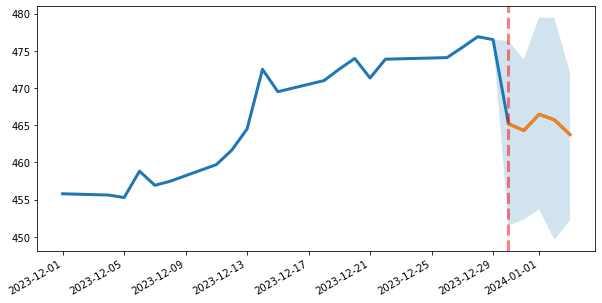

In [38]:
import matplotlib.pyplot as plt
to_plot = to_forecast['2023-12-01':]

plt.figure(figsize=(10,5))
plt.plot(pd.concat([to_plot, forecast['0.5']]), linewidth=3)
plt.plot(pd.concat([forecast['0.5']]), linewidth=3)
plt.axvline(forecast.index[0], linestyle='--', color='red', linewidth=3, alpha=0.5)
plt.fill_between([to_plot.index[-1]] + list(forecast.index), [to_plot[-1]] + list(forecast['0.1']), [to_plot[-1]] + list(forecast['0.9']), alpha=0.2)
plt.gcf().autofmt_xdate()
plt.show()

Can you try to forecast and visualize the close price?

To increase the forecast duration, we will need to go back to the beginning and train the model with higher `prediction_length`. 

## Cleaning up

**As usual, remember to clean up the model and endpoints to avoid any charges!**

In [34]:
predictor.delete_model()
predictor.delete_endpoint(delete_endpoint_config=True)

INFO:sagemaker:Deleting model with name: deepar-forecast-2024-01-05-03-01-47-446
INFO:sagemaker:Deleting endpoint configuration with name: deepar-forecast-2024-01-05-03-01-47-446
INFO:sagemaker:Deleting endpoint with name: deepar-forecast-2024-01-05-03-01-47-446
